<a href="https://colab.research.google.com/github/BuzzPonto/UAP/blob/main/UAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import os

os.environ['KAGGLE_USERNAME'] = "alfianaja"
os.environ['KAGGLE_KEY'] = "KGAT_680196a144e5900b2627196aab77b248"

!kaggle datasets list

ref                                                              title                                                  size  lastUpdated                 downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  -----------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
wardabilal/spotify-global-music-dataset-20092025                 Spotify Global Music Dataset (2009–2025)            1289021  2025-11-11 09:43:05.933000          16387        432  1.0              
neurocipher/heartdisease                                         Heart Disease                                          3491  2025-12-11 15:29:14.327000           2114         87  1.0              
neurocipher/student-performance                                  Student Performance                                   49705  2025-12-12 12:06:28.973000           1261         66  1.0              
kundanbedm

In [18]:
!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k
!unzip -q ocular-disease-recognition-odir5k.zip -d dataset_mata
!ls dataset_mata

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/ocular-disease-recognition-odir5k
License(s): other
ocular-disease-recognition-odir5k.zip: Skipping, found more recently modified local copy (use --force to force download)
replace dataset_mata/ODIR-5K/ODIR-5K/Testing Images/1000_left.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
n
full_df.csv  ODIR-5K  preprocessed_images


CNN

In [24]:
import pandas as pd
import numpy as np
import os
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

# 1. NYALAKAN BALANCING DATA (Wajib agar tidak bias)
# Kita samakan semua kelas ke 1000 gambar saja agar training tidak terlalu berat tapi adil
target_count = 1000
balanced_list = []
for label in ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']:
    class_df = final_df[final_df['target'] == label]
    resampled_class = resample(class_df, replace=True, n_samples=target_count, random_state=42)
    balanced_list.append(resampled_class)

balanced_df = pd.concat(balanced_list)

# 2. SPLIT DATA
train_df, test_df = train_test_split(balanced_df, test_size=0.2, stratify=balanced_df['target'], random_state=42)

# 3. GENERATOR SEDERHANA (Hapus CLAHE dulu agar model fokus ke pola dasar)
# Kita hanya pakai Horizontal Flip agar data bervariasi
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_dataframe(
    train_df, directory=img_dir, x_col='filename', y_col='target',
    target_size=(150, 150), # Kecilkan sedikit agar training cepat dan fokus ke fitur besar
    batch_size=32, class_mode='categorical', subset='training'
)

val_gen = datagen.flow_from_dataframe(
    train_df, directory=img_dir, x_col='filename', y_col='target',
    target_size=(150, 150), batch_size=32, class_mode='categorical', subset='validation'
)

# 4. ARSITEKTUR CNN STANDAR (Tanpa Batch Norm yang bikin stuck)
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(8, activation='softmax')
])

# Ganti Learning Rate ke standar Adam (0.001) agar model cepat "bangun" dari tebakan acak
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 5. TRAINING
# Pantau di Epoch 1-3. Jika Accuracy naik di atas 0.15, berarti model SUDAH BELAJAR.
history = model.fit(train_gen, validation_data=val_gen, epochs=20)

model.save('Base_CNN.h5')

Found 5120 validated image filenames belonging to 8 classes.
Found 1280 validated image filenames belonging to 8 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 23s 108ms/step - accuracy: 0.1402 - loss: 2.0934 - val_accuracy: 0.2352 - val_loss: 1.9841
Epoch 2/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 15s 97ms/step - accuracy: 0.2417 - loss: 1.9484 - val_accuracy: 0.3430 - val_loss: 1.7796
Epoch 3/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step - accuracy: 0.3138 - loss: 1.7898 - val_accuracy: 0.3828 - val_loss: 1.6334
Epoch 4/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 17s 95ms/step - accuracy: 0.3573 - loss: 1.6878 - val_accuracy: 0.4336 - val_loss: 1.5207
Epoch 5/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 15s 96ms/step - accuracy: 0.4109 - loss: 1.5490 - val_accuracy: 0.4992 - val_loss: 1.4571
Epoch 6/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 15s 93ms/step - accuracy: 0.4605 - loss: 1.4554 - val_accuracy: 0.4781 - val_loss: 1.3826
Epoch 7/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 16s 99ms/step - accuracy: 0.5252 - loss: 1.2969 - val_accuracy: 0.5875 - val_loss: 1.1750
Epoch 8/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 15s 95ms/step - accuracy: 0.5823 - loss: 1.1486 

Found 1600 validated image filenames belonging to 8 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step

--- Classification Report (Perbaikan Urutan) ---
              precision    recall  f1-score   support

           A       0.86      0.90      0.88       200
           C       0.90      0.96      0.93       200
           D       0.63      0.43      0.51       200
           G       0.86      0.89      0.87       200
           H       0.94      1.00      0.97       200
           M       0.96      0.95      0.95       200
           N       0.54      0.46      0.50       200
           O       0.59      0.75      0.66       200

    accuracy                           0.79      1600
   macro avg       0.79      0.79      0.78      1600
weighted avg       0.79      0.79      0.78      1600



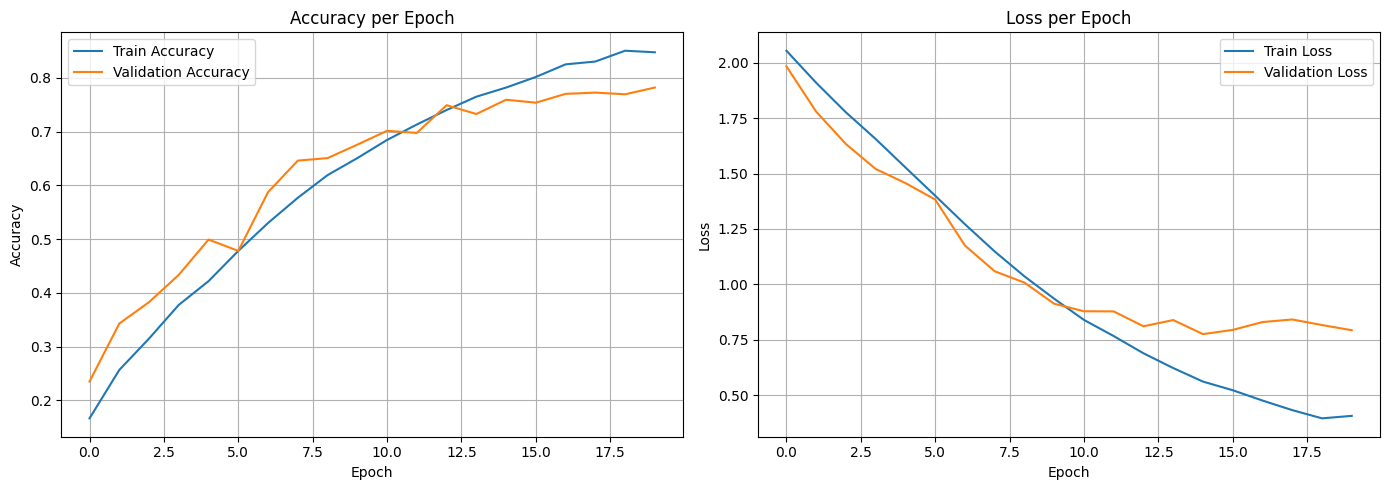

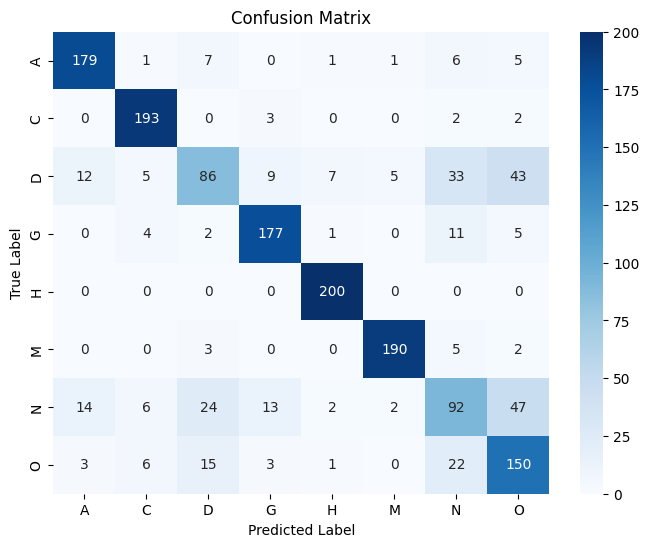

In [31]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# =====================================================
# 1. TEST GENERATOR (shuffle=False WAJIB)
# =====================================================
test_datagen = ImageDataGenerator(rescale=1./255)
eval_gen = test_datagen.flow_from_dataframe(
    test_df,
    directory=img_dir,
    x_col='filename',
    y_col='target',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# =====================================================
# 2. PREDIKSI MODEL
# =====================================================
Y_pred = model.predict(eval_gen)
y_pred = np.argmax(Y_pred, axis=1)

# =====================================================
# 3. LABEL ASLI
# =====================================================
y_true = eval_gen.classes
class_labels = list(eval_gen.class_indices.keys())

# =====================================================
# 4. CLASSIFICATION REPORT
# =====================================================
print('\n--- Classification Report (Perbaikan Urutan) ---')
print(classification_report(y_true, y_pred, target_names=class_labels))

# =====================================================
# 5. GRAFIK LOSS & ACCURACY
# =====================================================
plt.figure(figsize=(14, 5))

# ---- Accuracy ----
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# ---- Loss ----
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# =====================================================
# 6. CONFUSION MATRIX
# =====================================================
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_labels,
    yticklabels=class_labels
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


Data Prep

In [26]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# =========================
# BALANCING DATA
# =========================
target_count = 1000
balanced_list = []

for label in ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']:
    class_df = final_df[final_df['target'] == label]
    resampled = resample(
        class_df,
        replace=True,
        n_samples=target_count,
        random_state=42
    )
    balanced_list.append(resampled)

balanced_df = pd.concat(balanced_list)

# =========================
# SPLIT DATA
# =========================
train_df, test_df = train_test_split(
    balanced_df,
    test_size=0.2,
    stratify=balanced_df['target'],
    random_state=42
)

# =========================
# IMAGE GENERATOR
# =========================
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = datagen.flow_from_dataframe(
    train_df,
    directory=img_dir,
    x_col='filename',
    y_col='target',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_dataframe(
    train_df,
    directory=img_dir,
    x_col='filename',
    y_col='target',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 5120 validated image filenames belonging to 8 classes.
Found 1280 validated image filenames belonging to 8 classes.


Train MobileNet

In [27]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2

base_mobilenet = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_mobilenet.trainable = False

mobilenet_model = models.Sequential([
    base_mobilenet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(8, activation='softmax')
])

mobilenet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_mobilenet = mobilenet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20
)

mobilenet_model.save("MobileNetV2_Model.h5")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


160/160 ━━━━━━━━━━━━━━━━━━━━ 39s 142ms/step - accuracy: 0.3340 - loss: 1.8325 - val_accuracy: 0.4711 - val_loss: 1.3865
Epoch 2/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.4472 - loss: 1.4698 - val_accuracy: 0.5437 - val_loss: 1.2668
Epoch 3/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 18s 110ms/step - accuracy: 0.5010 - loss: 1.3200 - val_accuracy: 0.5672 - val_loss: 1.2046
Epoch 4/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - accuracy: 0.5185 - loss: 1.2853 - val_accuracy: 0.5742 - val_loss: 1.1232
Epoch 5/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 17s 109ms/step - accuracy: 0.5573 - loss: 1.1908 - val_accuracy: 0.6094 - val_loss: 1.0688
Epoch 6/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 117ms/step - accuracy: 0.5871 - loss: 1.1358 - val_accuracy: 0.6203 - val_loss: 1.0371
Epoch 7/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 18s 109ms/step - accuracy: 0.6074 - loss: 1.0687 - val_accuracy: 0.6195 - val_loss: 1.0075
Epoch 8/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.6082 - loss: 1.0455 - val

Eval

Found 1600 validated image filenames belonging to 8 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step

=== Classification Report: MobileNetV2 ===
              precision    recall  f1-score   support

           A       0.80      0.82      0.81       200
           C       0.87      0.92      0.89       200
           D       0.44      0.29      0.35       200
           G       0.90      0.82      0.86       200
           H       0.97      0.99      0.98       200
           M       0.95      0.89      0.92       200
           N       0.51      0.38      0.43       200
           O       0.37      0.61      0.47       200

    accuracy                           0.71      1600
   macro avg       0.73      0.71      0.71      1600
weighted avg       0.73      0.71      0.71      1600



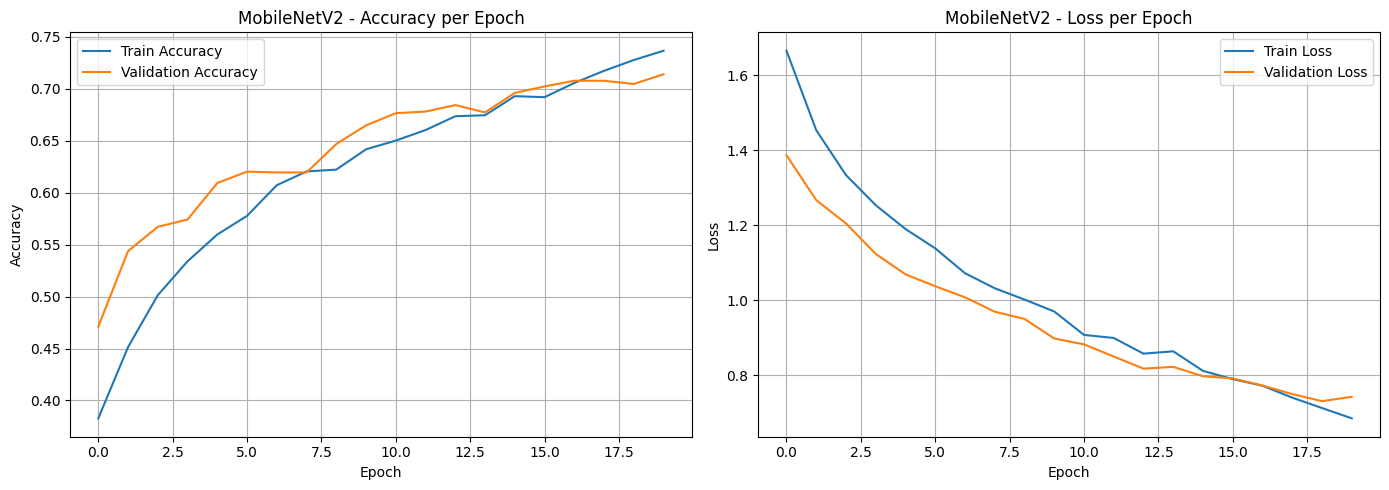

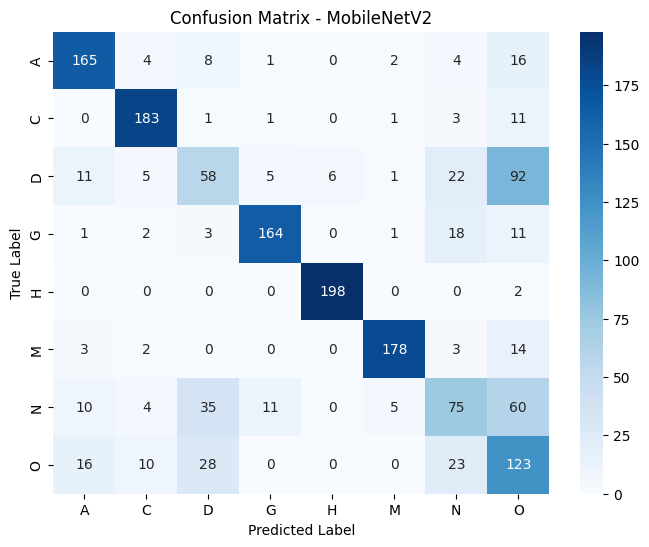

In [32]:
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# =====================================================
# 1. TEST GENERATOR (shuffle=False WAJIB)
# =====================================================
test_datagen = ImageDataGenerator(rescale=1./255)

eval_gen_mobilenet = test_datagen.flow_from_dataframe(
    test_df,
    directory=img_dir,
    x_col='filename',
    y_col='target',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# =====================================================
# 2. PREDIKSI MODEL
# =====================================================
Y_pred = mobilenet_model.predict(eval_gen_mobilenet)
y_pred = np.argmax(Y_pred, axis=1)

# =====================================================
# 3. LABEL ASLI
# =====================================================
y_true = eval_gen_mobilenet.classes
class_labels = list(eval_gen_mobilenet.class_indices.keys())

# =====================================================
# 4. CLASSIFICATION REPORT
# =====================================================
print("\n=== Classification Report: MobileNetV2 ===")
print(classification_report(y_true, y_pred, target_names=class_labels))

# =====================================================
# 5. GRAFIK ACCURACY & LOSS
# =====================================================
plt.figure(figsize=(14, 5))

# ---- Accuracy ----
plt.subplot(1, 2, 1)
plt.plot(history_mobilenet.history['accuracy'], label='Train Accuracy')
plt.plot(history_mobilenet.history['val_accuracy'], label='Validation Accuracy')
plt.title('MobileNetV2 - Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# ---- Loss ----
plt.subplot(1, 2, 2)
plt.plot(history_mobilenet.history['loss'], label='Train Loss')
plt.plot(history_mobilenet.history['val_loss'], label='Validation Loss')
plt.title('MobileNetV2 - Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# =====================================================
# 6. CONFUSION MATRIX
# =====================================================
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_labels,
    yticklabels=class_labels
)
plt.title('Confusion Matrix - MobileNetV2')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


Train Efficient

In [35]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# =====================================================
# 1. IMAGE GENERATOR (WAJIB PREPROCESS_INPUT)
# =====================================================
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_gen = train_datagen.flow_from_dataframe(
    train_df,
    directory=img_dir,
    x_col='filename',
    y_col='target',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_gen = val_datagen.flow_from_dataframe(
    train_df,
    directory=img_dir,
    x_col='filename',
    y_col='target',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# =====================================================
# 2. BASE MODEL (STAGE 1 — FREEZE TOTAL)
# =====================================================
base_efficientnet = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_efficientnet.trainable = False

model = models.Sequential([
    base_efficientnet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(
        256,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(1e-4)
    ),
    layers.Dropout(0.5),
    layers.Dense(8, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# =====================================================
# 3. TRAINING STAGE 1 (HEAD TRAINING)
# =====================================================
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    ]
)

# =====================================================
# 4. STAGE 2 — FINE TUNING (UNFREEZE 30 LAYER TERAKHIR)
# =====================================================
for layer in base_efficientnet.layers[:-30]:
    layer.trainable = False
for layer in base_efficientnet.layers[-30:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_efficientnet = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6)
    ]
)

model.save("EfficientNetB0_Best.h5")


Found 5120 validated image filenames belonging to 8 classes.
Found 1280 validated image filenames belonging to 8 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 93s 451ms/step - accuracy: 0.3479 - loss: 1.7775 - val_accuracy: 0.4844 - val_loss: 1.4083
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 65s 406ms/step - accuracy: 0.4801 - loss: 1.4626 - val_accuracy: 0.4875 - val_loss: 1.3528
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 67s 416ms/step - accuracy: 0.5135 - loss: 1.3605 - val_accuracy: 0.5164 - val_loss: 1.2971
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 66s 410ms/step - accuracy: 0.5262 - loss: 1.3287 - val_accuracy: 0.5469 - val_loss: 1.2402
Epoch 5/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 67s 421ms/step - accuracy: 0.5397 - loss: 1.2677 - val_accuracy: 0.5500 - val_loss: 1.2127
Epoch 6/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 65s 407ms/step - accuracy: 0.5358 - loss: 1.2528 - val_accuracy: 0.5727 - val_loss: 1.1740
Epoch 7/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 65s 409ms/step - accuracy: 0.5607 - loss: 1.2254 - val_accuracy: 0.5273 - val_loss: 1.2179
Epoch 8/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 82s 409ms/step - accuracy: 0.5681 - loss: 1

Eval

Found 1600 validated image filenames belonging to 8 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step

=== Classification Report: EfficientNetB0 (Improved) ===
              precision    recall  f1-score   support

           A       0.11      0.01      0.01       200
           C       0.00      0.00      0.00       200
           D       0.00      0.00      0.00       200
           G       0.13      1.00      0.22       200
           H       0.00      0.00      0.00       200
           M       0.00      0.00      0.00       200
           N       0.00      0.00      0.00       200
           O       0.00      0.00      0.00       200

    accuracy                           0.13      1600
   macro avg       0.03      0.13      0.03      1600
weighted avg       0.03      0.13      0.03      1600



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


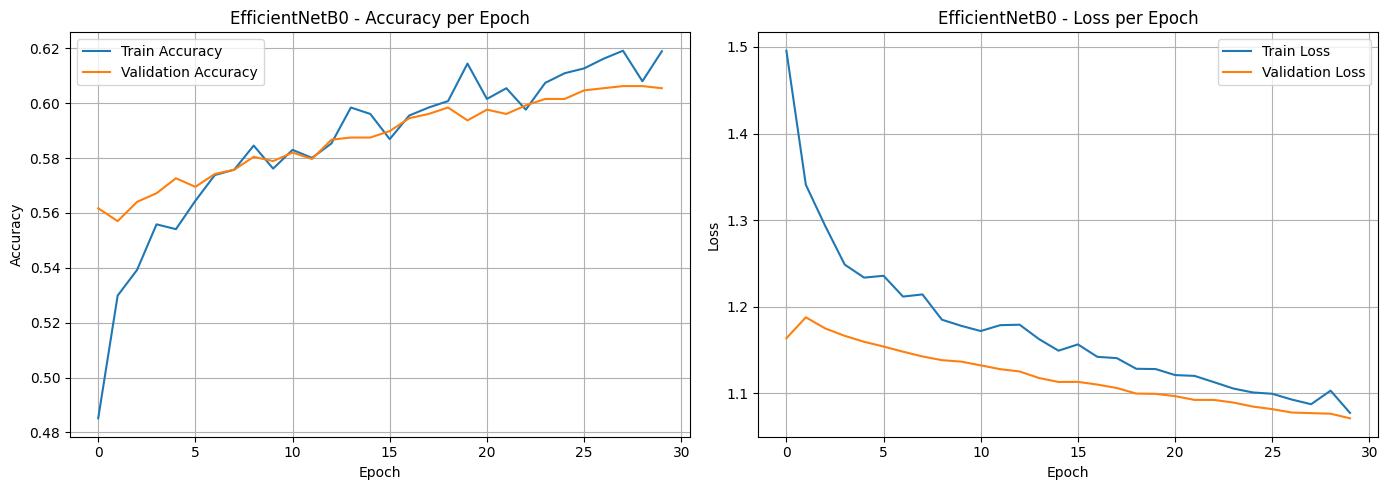

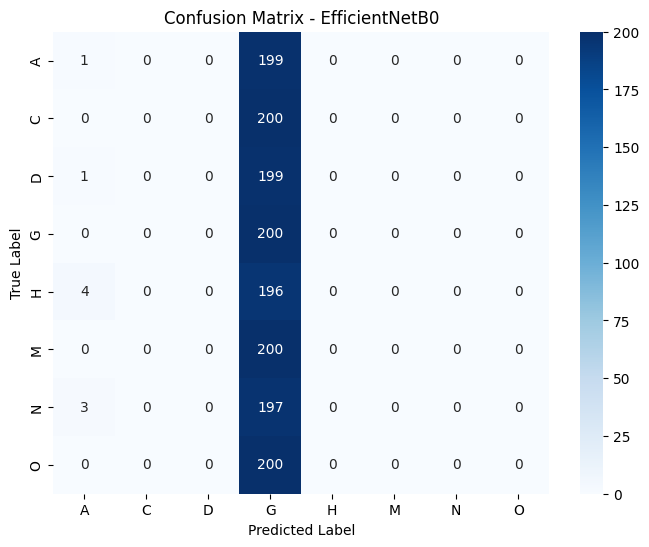

In [36]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# =====================================================
# 1. TEST GENERATOR (shuffle=False WAJIB)
# =====================================================
test_datagen = ImageDataGenerator(rescale=1./255)

eval_gen_efficientnet = test_datagen.flow_from_dataframe(
    test_df,
    directory=img_dir,
    x_col='filename',
    y_col='target',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# =====================================================
# 2. PREDIKSI MODEL
# =====================================================
Y_pred = efficientnet_model.predict(eval_gen_efficientnet)
y_pred = np.argmax(Y_pred, axis=1)

# =====================================================
# 3. LABEL ASLI
# =====================================================
y_true = eval_gen_efficientnet.classes
class_labels = list(eval_gen_efficientnet.class_indices.keys())

# =====================================================
# 4. CLASSIFICATION REPORT
# =====================================================
print("\n=== Classification Report: EfficientNetB0 (Improved) ===")
print(classification_report(y_true, y_pred, target_names=class_labels))

# =====================================================
# 5. GRAFIK LOSS & ACCURACY
# =====================================================
plt.figure(figsize=(14, 5))

# ---- Accuracy ----
plt.subplot(1, 2, 1)
plt.plot(history_efficientnet.history['accuracy'], label='Train Accuracy')
plt.plot(history_efficientnet.history['val_accuracy'], label='Validation Accuracy')
plt.title('EfficientNetB0 - Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# ---- Loss ----
plt.subplot(1, 2, 2)
plt.plot(history_efficientnet.history['loss'], label='Train Loss')
plt.plot(history_efficientnet.history['val_loss'], label='Validation Loss')
plt.title('EfficientNetB0 - Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# =====================================================
# 6. CONFUSION MATRIX
# =====================================================
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_labels,
    yticklabels=class_labels
)
plt.title('Confusion Matrix - EfficientNetB0')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
